# Strategies for Winning on Jeopardy

This analysis draws on a data file containing close to 20K questions and answers that have been asked on Jeopardy shows over time.  The objective is to clean and parse the data to figure out whether there are any potential strategies for studying questions that could enhance the money one wins given entry onto a jeopardy show. The analysis looks at the prevalence of key words and phrases to answer questions such as:  How often are answers part of the questions?  Are there certain types of questions that are associated with higher value monetary amounts and therefore would suggest a focused strategy for studying?  How often have questions from past shows shown up in current ones?

In [126]:
import pandas as pd

jeopardy = pd.read_csv("jeopardy.csv")
print(jeopardy.head(5))
print(jeopardy.columns)
newlabels = []
#Clean the column names and remove leading white spaces
for i in jeopardy.columns:
    print(i)
    newlabels.append(i.lstrip())

jeopardy.columns = newlabels
print(jeopardy.columns)
print(jeopardy.shape)

   Show Number    Air Date      Round                         Category  Value  \
0         4680  2004-12-31  Jeopardy!                          HISTORY   $200   
1         4680  2004-12-31  Jeopardy!  ESPN's TOP 10 ALL-TIME ATHLETES   $200   
2         4680  2004-12-31  Jeopardy!      EVERYBODY TALKS ABOUT IT...   $200   
3         4680  2004-12-31  Jeopardy!                 THE COMPANY LINE   $200   
4         4680  2004-12-31  Jeopardy!              EPITAPHS & TRIBUTES   $200   

                                            Question      Answer  
0  For the last 8 years of his life, Galileo was ...  Copernicus  
1  No. 2: 1912 Olympian; football star at Carlisl...  Jim Thorpe  
2  The city of Yuma in this state has a record av...     Arizona  
3  In 1963, live on "The Art Linkletter Show", th...  McDonald's  
4  Signer of the Dec. of Indep., framer of the Co...  John Adams  
Index(['Show Number', ' Air Date', ' Round', ' Category', ' Value',
       ' Question', ' Answer'],
      dtype

In [127]:
#This code develops a function to normalize questions and take a string,
#convert to lowercase, remove punctuation and return the string

punctuation = ["'",'''"''',".","(",")",",",":"]
other_clean = ["target=_blank>","</a>"]
def normalize_text(string):
    textstr = str.lower(string)
    for i in punctuation:
        textstr = str.replace(textstr,i,"")
    for i in other_clean:
        textstr = str.replace(textstr,i,"")
    return(textstr)

jeopardy["clean_question"] = jeopardy["Question"].apply(normalize_text)
jeopardy["clean_answer"] = jeopardy["Answer"].apply(normalize_text)
print(jeopardy["clean_question"].head(5))
print(jeopardy["clean_answer"].head(5))

0    for the last 8 years of his life galileo was u...
1    no 2 1912 olympian; football star at carlisle ...
2    the city of yuma in this state has a record av...
3    in 1963 live on the art linkletter show this c...
4    signer of the dec of indep framer of the const...
Name: clean_question, dtype: object
0    copernicus
1    jim thorpe
2       arizona
3     mcdonalds
4    john adams
Name: clean_answer, dtype: object


In [128]:
#Normalize dollar values
punctuation = ["$",".",","]
def normalize_dollarvalues(string):
    textstr = string
    for i in punctuation:
        textstr = str.replace(textstr,i,"")
    try:
        value = int(textstr)
    except ValueError:
        value = 0
    return(value)

jeopardy["clean_value"]=jeopardy["Value"].apply(normalize_dollarvalues)
print(jeopardy["clean_value"].head(2))

jeopardy["datetime"] = pd.to_datetime(jeopardy["Air Date"], yearfirst=True)
print(jeopardy["datetime"].head(2))

0    200
1    200
Name: clean_value, dtype: int64
0   2004-12-31
1   2004-12-31
Name: datetime, dtype: datetime64[ns]


In [129]:
#How often is the answer deducible from the question?
#How often are new questions a repeat of older questions?

def jeopardyrow(series):
    split_answer = series["clean_answer"].split(" ")
    split_question = series["clean_question"].split(" ")
    try:
        split_answer.remove("the")
    except ValueError:
        split_answer = split_answer
    match_count = 0
    if len(split_answer) == 0:
        return 0
    else:
        for i in split_answer:
            if i in split_question:
                match_count += 1
                #print("Found Match")
        return match_count/len(split_answer)

jeopardy["answer_in_question"]=jeopardy.apply(jeopardyrow, axis=1)
#print(jeopardy["answer_in_question"].head())
mean_answer_in_question = jeopardy["answer_in_question"].mean()
print("Percent of answers that were in questions: {}".format(round(mean_answer_in_question*100,2)))
    

Percent of answers that were in questions: 5.83


### Percent of questions in answers

The share of answers in question on jeopardy only occurs about 6% of the time.  This percentage is low suggesting a winning strategy would not be to answer with part of the question when one does not know the answer.

In [130]:
#Investigating recycled questions
import time
def recycled_questions(wordnum):

    #first sort based on air date
    jeopardy.sort_values("Air Date", ascending=True)

    #create empty list and empty set
    question_overlap = []
    terms_used = {}
    for i,row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        new_question = [word for word in split_question if len(word) >= wordnum]
        #print(split_question)
        #print(new_question)
        match_count = 0
        #calculate share of words > 5 that have occurred in Jeopardy rounds
        if len(new_question) != 0:
            #add all of the words in each row to terms_used list
            #print(len(new_question))
            for word in new_question:
                if word in terms_used:
                    match_count += 1
                    terms_used[word]+=1
                else:
                    terms_used[word]=1
            question_overlap.append(match_count/len(new_question))
        else:
            question_overlap.append(0)
    jeopardy["question_overlap"] = question_overlap
    percentqs = round(jeopardy["question_overlap"].mean()*100,2)
    print("Percent of questions asked previously (words > {}): {}".format(wordnum, percentqs))
    print("Number of words: {}".format(len(terms_used)))
    return percentqs, terms_used



In [112]:
terms_used5 = recycled_questions(5)
terms_used7 = recycled_questions(7)
terms_used9 = recycled_questions(9)
terms_used11 = recycled_questions(11)

Percent of questions asked previously (words > 5): 74.47
Number of words: 29500
Percent of questions asked previously (words > 7): 61.58
Number of words: 19951
Percent of questions asked previously (words > 9): 35.22
Number of words: 10265
Percent of questions asked previously (words > 11): 11.12
Number of words: 4681


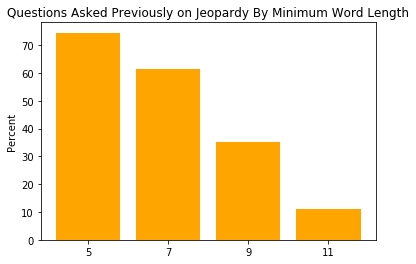

In [119]:
%matplotlib inline
import matplotlib.pyplot as plt

percentqs_array = [terms_used5[0],terms_used7[0],terms_used9[0],terms_used11[0]]
len(percentqs_array)

def format_bargraphs(barnames,yval,colorname):
    # have maximum length of 10 for the character names
    #print(results)
    new_bar_values = []
    y_pos = np.arange(len(yval))
    plt.bar(y_pos, yval, color=colorname)
    plt.xticks(y_pos, barnames)
    
format_bargraphs([5,7,9,11],percentqs_array,"orange")
plt.ylabel("Percent")
plt.title("Questions Asked Previously on Jeopardy By Minimum Word Length")
plt.show()

##### Percent of questions asked on previous shows

Analyzing questions based on critical words (characters > 5) nearly 75% questions have been asked on previous shows this suggests that studying past questions could be helpful for winning on jeopardy.  However, if we restrict the count to words with at least 9 characters if we assume more unique words are typically longer then we find only 35% of questions have asked previously and the number is far smaller when focusing on words that are 11 characters in length.  This suggests that we can identify common words to focus on that could pay off more and have a greater chance of showing up on future jeopardy shows.

In [120]:
#Low value versus high value questions

#return indicator of whether a question is high value (worth over 800)
def qsvalue(datarow,dollaramt):
    return(datarow["clean_value"] >= dollaramt)

#count words associated with high value amounts and those associated with low value across the entire sample
def valuecount(wordlist,dollaramt):
    jeopardy["high_value"]=jeopardy.apply(lambda datarow: qsvalue(datarow,dollaramt),axis=1)
    #print("High_value questions:",sum(jeopardy["high_value"]))
    low_count = {}
    high_count = {}
    for i, row in jeopardy.iterrows():
        split_question = row["clean_question"].split(" ")
        for word in wordlist:
            if word not in low_count:
                low_count[word]=0
                high_count[word]=0
            if word in split_question:
                if row["high_value"]==1:
                    high_count[word] += 1
                else:
                    low_count[word] += 1
    return(high_count,low_count)



In [136]:
#now we want to check for common words where the difference is disproportionately high value versus low value
#lets focus on the 20 words (out of 20K) that show up the most in the terms_used sample
terms5_sort = sorted(terms_used5[1].items(), key=lambda x:x[1], reverse=True)
terms7_sort = sorted(terms_used7[1].items(), key=lambda x:x[1], reverse=True)
terms9_sort = sorted(terms_used9[1].items(), key=lambda x:x[1], reverse=True)
#examine some of the top used words in the list
print("Most common words with at least 5 letters")
for row in terms5_sort[0:20]:
    print(row)
print("\n")
print("Most common words with at least 7 letters")
for row in terms7_sort[0:20]:
    print(row)
print("\n")
print("Most common words with at least 9 letters")
for row in terms9_sort[0:20]:
    print(row)
print("\n")

Most common words with at least 5 letters
('these', 1389)
('first', 950)
('about', 551)
('called', 521)
('named', 513)
('country', 472)
('state', 440)
('after', 425)
('title', 369)
('which', 361)
('known', 351)
('years', 314)
('played', 299)
('became', 287)
('wrote', 286)
('before', 267)
('novel', 264)
('president', 259)
('world', 258)
('american', 257)


Most common words with at least 7 letters
('country', 472)
('president', 259)
('american', 257)
('capital', 254)
('national', 183)
('largest', 179)
('british', 166)
('meaning', 162)
('century', 159)
('musical', 153)
('company', 150)
('between', 145)
('reports', 145)
('founded', 141)
('character', 141)
('include', 138)
('million', 127)
('popular', 119)
('because', 111)
('through', 104)


Most common words with at least 9 letters
('president', 259)
('character', 141)
('university', 98)
('published', 92)
('introduced', 77)
('including', 75)
('something', 74)
('washington', 67)
('california', 66)
('government', 63)
('presidential', 61)
('

In [139]:
import numpy as np
# look at differences between observed and expected (top 100 words)
# words that have the greatest positive difference given that are ranked in the top 50 most common words (over a certain length)
def high_value_words(terms,maxwords,dollaramt):
    comparison_terms = list(terms)[0:maxwords]
    wordlist = []
    for word in comparison_terms:
        wordlist.append(word[0])
    #print("Top {} most common words:".format(maxwords))
    #print(comparison_terms)
    #print("\n")
    observed_expected = {}
    share_highvalue = []
    #probably more efficient to send the entire comparison_terms (wordlist) to have efficiency gains
    result = valuecount(wordlist,dollaramt)
    #print(result)
    highvalue_dict = result[0]
    lowvalue_dict = result[1]
    exp_share = sum(jeopardy["high_value"])/len(jeopardy["high_value"])
    share_highvalue_dict = {}
    for word in wordlist:
        share_highvalue_dict[word] = highvalue_dict[word]/(highvalue_dict[word]+lowvalue_dict[word])
        share_highvalue.append(share_highvalue_dict[word])
    share_highvalue_dict_sort = sorted(share_highvalue_dict.items(), key=lambda x:x[1], reverse=True)
    print("Top 10 words (out of {} most common) with the greatest high value share (greater than ${}) :".format(maxwords,dollaramt))
    for row in share_highvalue_dict_sort[0:10]:
        print(row)
    print("\n")
    print("Share of high value questions in sample: {}".format(exp_share))
    print("Share (out of {} most common) words that have high value questions (greater than ${}): {}".
          format(maxwords, dollaramt, np.mean(share_highvalue)))
    print("\n")
    print("\n")
    return(sum(jeopardy["high_value"]), highvalue_dict, lowvalue_dict)

In [140]:
#note the iteration process is quite slow.  Probably would be better to tokenize it or place into matrix so we don't have to 
#go through all the loops
share5_highvalue500 = high_value_words(terms5_sort,50,500)
share7_highvalue500 = high_value_words(terms7_sort,50,500)
share9_highvalue500 = high_value_words(terms9_sort,50,500)
share5_highvalue800 = high_value_words(terms5_sort,50,800)
share7_highvalue800 = high_value_words(terms7_sort,50,800)
share9_highvalue800 = high_value_words(terms9_sort,50,800)

Top 10 words (out of 50 most common) with the greatest high value share (greater than $500) :
('french', 0.7053941908713693)
('greek', 0.7025316455696202)
('whose', 0.6727272727272727)
('known', 0.6628242074927954)
('island', 0.6618357487922706)
('meaning', 0.65625)
('great', 0.6464646464646465)
('means', 0.6439024390243903)
('house', 0.6392405063291139)
('named', 0.6354581673306773)


Share of high value questions in sample: 0.5709285464273214
Share (out of 50 most common) words that have high value questions (greater than $500): 0.5933361100400942




Top 10 words (out of 50 most common) with the greatest high value share (greater than $500) :
('reports', 0.7172413793103448)
('italian', 0.7142857142857143)
('another', 0.6842105263157895)
('meaning', 0.65625)
('university', 0.6559139784946236)
('college', 0.6282051282051282)
('english', 0.6276595744680851)
('original', 0.6266666666666667)
('something', 0.625)
('against', 0.6125)


Share of high value questions in sample: 0.57092854642

In [124]:
#applying the Chi-squared test to high and low-counts
import scipy.stats as stats

def compute_chi_squared(highvaluevars):

    #expected share in distribution
    exp_share = highvaluevars[0]/len(jeopardy["high_value"])  #this is the share that is in sample population
    highvalue_count = highvaluevars[1]
    lowvalue_count = highvaluevars[2]

    exp_high = []
    exp_low = []
    exp = []
    obs_high = []
    obs_low = []
    obs = []
    for word, v in highvalue_count.items():
        #total_prop is share of question in total questions
        exp.append([exp_share*(highvalue_count[word]+lowvalue_count[word]),(1-exp_share)*(highvalue_count[word]+lowvalue_count[word])])
        obs.append([highvalue_count[word],lowvalue_count[word]])
        exp_high.append(exp_share*(highvalue_count[word]+lowvalue_count[word]))
        exp_low.append((1-exp_share)*(highvalue_count[word]+lowvalue_count[word]))
        #print([highvalue_count,exp_share*(highvalue_count[word]+lowvalue_count[word])])
        obs_high.append(highvalue_count[word])
        obs_low.append(lowvalue_count[word])

    #create chi-squared for all high value questions
    print("Chi-squared for high value counts: {}".format(stats.chisquare(obs_high,exp_high)))
    print("Chi-squared for low value counts: {}".format(stats.chisquare(obs_low,exp_low)))
    print("\n")

In [125]:
compute_chi_squared(share5_highvalue500)
compute_chi_squared(share7_highvalue500)
compute_chi_squared(share9_highvalue500)
compute_chi_squared(share5_highvalue800)
compute_chi_squared(share7_highvalue800)
compute_chi_squared(share9_highvalue800)

Chi-squared for high value counts: Power_divergenceResult(statistic=57.068459647104412, pvalue=0.20025976710910895)
Chi-squared for low value counts: Power_divergenceResult(statistic=75.936099784481797, pvalue=0.008115371881753243)


Chi-squared for high value counts: Power_divergenceResult(statistic=29.26905251697594, pvalue=0.98866918699306039)
Chi-squared for low value counts: Power_divergenceResult(statistic=38.94581536404047, pvalue=0.84759613321258875)


Chi-squared for high value counts: Power_divergenceResult(statistic=33.944812665944788, pvalue=0.94980611116822877)
Chi-squared for low value counts: Power_divergenceResult(statistic=45.16744796873995, pvalue=0.62925117187710433)


Chi-squared for high value counts: Power_divergenceResult(statistic=72.977970498911858, pvalue=0.014749442924201302)
Chi-squared for low value counts: Power_divergenceResult(statistic=56.351797512407416, pvalue=0.21915352706695418)


Chi-squared for high value counts: Power_divergenceResult(statistic=5

### Analyzing the variation between high and low value counts

Our analysis shows that if we use a thresshold of 500 there is little differences in the times that top 50 most common are associated with high paying questions versus low-paying questions compared to what is expected in the full set of questions using both thresshold.  However, increasing the thresshold for high-value to 800 it is observed that there could be a statistically significant difference in the share of high value questions compared to the norm where the character length of words is at least 5 or 7 characters in length.

## Conclusions

We found that there is frequent recycling of questions on Jeopardy with 75% of words having shown up on multiple Jeopardy shows.  
This led us to identify the top 50 common words (and associated questions) that come up frequently and suggests areas to concentrate on to study to get more questions right on Jeopardy.  However, by focusing on these common questions and analyzing the share that were associated with higher values (on average) we were able to narrow down the set of questions that both commonly come up and likewise are more likely to be associated with higher values.  Examining these words they tend to to be associated more likely in the category of historical, political knowledge suggesting that focusing on these types of questions could lead to greater pay-offs.
